In [31]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import tensorflow

import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import preprocess_input

In [32]:
Train_data = "C:/Users/gaura/Music/Ashwini Mam Project/maskdatasetvgg16/data/"
Test_data = "C:/Users/gaura/Music/Ashwini Mam Project/maskdatasetvgg16/test/"

train_data_df = pd.DataFrame(columns=['Image_path','Label'])
test_data_df = pd.DataFrame(columns=['Image_path'])

In [33]:
def load_dataframe(DF,path):
    labels_files = os.listdir(Train_data)
    image_paths = []
    labels = []
    for file in labels_files:
        path_file = path + file +'/'
        list_files = os.listdir(path_file)
        for image_path in list_files:
            image_paths.append(path_file + image_path)
            labels.append(file)
    DF['Image_path'] = image_paths
    DF['Label'] = labels
    return(DF)

In [34]:
train_data_df = load_dataframe(train_data_df,Train_data)
test_data_df = load_dataframe(test_data_df, Test_data)

train_data_df = shuffle(train_data_df)
test_data_df = shuffle(test_data_df)

encoder = LabelEncoder()
train_data_df['Label'] = encoder.fit_transform(train_data_df['Label'])
test_data_df['Label'] = encoder.fit_transform(test_data_df['Label'])

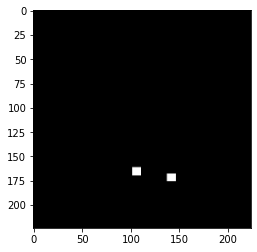

(224, 224, 3)

In [35]:
import cv2
def load_image(path):
    img = cv2.imread(path,1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    img = cv2.resize(img,(224,224))
    return img

img = load_image(train_data_df['Image_path'][0])
fig,ax = plt.subplots(1)
ax.imshow(img)
plt.show()
img.shape

In [36]:
x_train = []
for image_path in train_data_df['Image_path'] :
    img = load_image(image_path)
    img = preprocess_input(np.array(img, dtype=np.float32))
    x_train.append(img)
x_train = np.array(x_train)

In [37]:
x_test = []
for image_path in test_data_df['Image_path'] :
    img = load_image(image_path)
    img = preprocess_input(np.array(img, dtype=np.float32))
    x_test.append(img)
x_test = np.array(x_test)

In [38]:
y_train = train_data_df['Label'].to_list()
y_test = test_data_df['Label'].to_list()

In [39]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train,num_classes=3)
y_train = y_train.reshape(y_train.shape[0],1,1,y_train.shape[1])
y_test = to_categorical(y_test,num_classes=3)
y_test = y_test.reshape(y_test.shape[0],1,1,y_test.shape[1])

In [40]:
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D,Conv2DTranspose,Dropout,Dense,MaxPool2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = tensorflow.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable    

    x =  model.output
    x = Conv2D(512, kernel_size=3,padding ='same',activation="relu")(x)
    x = MaxPool2D()(x)
    x = Conv2D(256, kernel_size=3,padding ='same',activation="relu")(x)
    x = MaxPool2D()(x)
    x = Dense(512,activation = 'relu')(x)
    x = Dense(3,activation = 'softmax')(x)
    return(Model(inputs = model.input,outputs = x))

In [41]:
model = create_model(False)
import tensorflow
Optimizer = tensorflow.keras.optimizers.Adam(learning_rate = 1e-6,beta_1 = 0.9,decay = 1e-5)

model.compile(optimizer= Optimizer,loss= 'categorical_crossentropy',metrics= 'accuracy')

In [42]:
# EarlyStopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,min_delta = 0.01)
# # Model Checkpoint
# ModelCheckpoint = tensorflow.keras.callbacks.ModelCheckpoint("VGG-{val_loss:.3f}.h5",monitor='val_loss',save_best_only= True,save_weights_only=True)

In [43]:
# model_history = model.fit(x_train,y_train,epochs = 1,batch_size = 1,validation_data = (x_test,y_test),callbacks=[ModelCheckpoint,EarlyStopping])
model_history = model.fit(x_train,y_train, validation_data = (x_test,y_test),epochs=10,batch_size = 1)

Epoch 1/10
2093/2093 [==============================] - 611s 291ms/step - loss: 1.0156 - accuracy: 0.4926 - val_loss: 0.9613 - val_accuracy: 0.7619
Epoch 2/10
2093/2093 [==============================] - 461s 220ms/step - loss: 0.8998 - accuracy: 0.6101 - val_loss: 0.8623 - val_accuracy: 0.8095
Epoch 3/10
2093/2093 [==============================] - 461s 220ms/step - loss: 0.8074 - accuracy: 0.6808 - val_loss: 0.7773 - val_accuracy: 0.8095
Epoch 4/10
2093/2093 [==============================] - 462s 221ms/step - loss: 0.7408 - accuracy: 0.7272 - val_loss: 0.6995 - val_accuracy: 0.8571
Epoch 5/10
2093/2093 [==============================] - 461s 220ms/step - loss: 0.6883 - accuracy: 0.7754 - val_loss: 0.6620 - val_accuracy: 0.9524
Epoch 6/10
2093/2093 [==============================] - 459s 219ms/step - loss: 0.6444 - accuracy: 0.8084 - val_loss: 0.5907 - val_accuracy: 0.9524
Epoch 7/10
2093/2093 [==============================] - 447s 214ms/step - loss: 0.6069 - accuracy: 0.8194 - val_

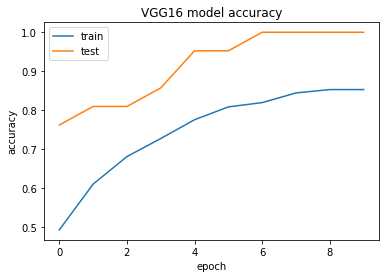

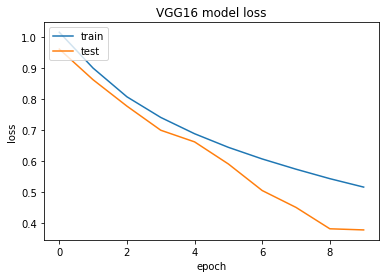

In [44]:
def plotModelAccuracy(history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(modelname+' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(modelname+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

plotModelAccuracy(model_history, 'VGG16')